# Validation

This notebook is for performing validation rollouts to test trained policies etc. on some test instances. 

In [1]:
%load_ext autoreload
%autoreload
from retro_branching.environments import EcoleBranching
from retro_branching.networks import BipartiteGCN
from retro_branching.agents import REINFORCEAgent, StrongBranchingAgent
from retro_branching.validators import ReinforcementLearningValidator
from retro_branching.utils import plot_val_line

import ecole
import torch
import os
import gzip
import pickle
from collections import defaultdict
import numpy as np

/scratch/zciccwf/py36/envs/rlgnn/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/scratch/zciccwf/py36/envs/rlgnn/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/scratch/zciccwf/py36/envs/rlgnn/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/scratch/zciccwf/py36/envs/rlgn

In [2]:
def get_most_recent_agent_checkpoint_foldername(agent_path):
    '''Given a path to a folders named <name>_<number>, will return foldername with highest <number>.'''
    foldernames = [name.split('_') for name in os.listdir(agent_path)]
    idx_to_num = {idx: int(num) for idx, num in zip(range(len(foldernames)), [name[-1] for name in foldernames])}
    latest_idx = max(idx_to_num, key=idx_to_num.get)
    foldername = [name for name in os.listdir(agent_path)][latest_idx]
    return foldername

## Initialise Agents

Load any saved NN parameters and initialise any agents you want to test.

In [11]:
%autoreload
DEVICE = 'cuda:1'
agents = {}

# # LOAD RL AGENTS
# ids = [57, 58, 60, 65]
# for i in ids:
#     # load agent params
#     agent = 'rl_gnn_{}'.format(i)
#     agent_path = '/scratch/datasets/retro_branching/reinforce_learner/rl_gnn/{}/'.format(agent)
#     foldername = get_most_recent_agent_checkpoint_foldername(agent_path)
# #     foldername='checkpoint_5'
#     path = '{}{}/'.format(agent_path, foldername)
#     policy_network = BipartiteGCN(DEVICE)
#     policy_network.load_state_dict(torch.load(path+'trained_params.pkl'))

#     # init agent
#     agent = REINFORCEAgent(policy_network=policy_network, device=DEVICE, name=agent_name)
#     agent.eval() # turn on evaluation mode
#     agents[agent_name] = agent

# LOAD GNN AGENT (NO RL)
policy_network = BipartiteGCN(DEVICE)
agent = 'gnn_21'
agent_path = '/scratch/datasets/retro_branching/supervised_learner/gnn/{}/'.format(agent)
foldername = get_most_recent_agent_checkpoint_foldername(agent_path)
# foldername='checkpoint_5'
path = '{}{}/'.format(agent_path, foldername)
print(path)
policy_network.load_state_dict(torch.load(path+'trained_params.pkl', map_location=DEVICE))
agent = REINFORCEAgent(policy_network=policy_network, device=DEVICE, name='gnn_100k')
agent.eval() # turn on evaluation mode
agents['gnn_100k'] = agent

DEVICE = 'cuda:0'
policy_network = BipartiteGCN(DEVICE)
path = '../scripts/'
print(path)
policy_network.load_state_dict(torch.load(path+'trained_params_dict_disabler.pkl', map_location=DEVICE))
agent = REINFORCEAgent(policy_network=policy_network, device=DEVICE, name='gnn_1k')
agent.eval() # turn on evaluation mode
agents['gnn_1k'] = agent

# LOAD STRONG BRANCHING AGENT
agent = StrongBranchingAgent(name='sb')
agents['sb'] = agent
print('Initialised agents {}'.format(agents.keys()))

print(agents)

/scratch/datasets/retro_branching/supervised_learner/gnn/gnn_21/checkpoint_60/
../scripts/
Initialised agents dict_keys(['gnn_100k', 'gnn_1k', 'sb'])
{'gnn_100k': <retro_branching.agents.REINFORCEAgent object at 0x7f569bb1abd0>, 'gnn_1k': <retro_branching.agents.REINFORCEAgent object at 0x7f569a627cd0>, 'sb': <retro_branching.agents.StrongBranchingAgent object at 0x7f569a5d7c50>}


## Run Validation Rollouts

In [12]:
# instances = ecole.instance.SetCoverGenerator(n_rows=100, n_cols=100, density=0.05)
instances = ecole.instance.SetCoverGenerator(n_rows=500, n_cols=1000, density=0.05)
print('Initialised instances.')


# init envs
envs = {}
for agent_name in agents.keys():
    envs[agent_name] = EcoleBranching()
print('Initialised agent envs.')

# metrics
metrics = ['num_nodes', 'solving_time', 'lp_iterations']
print('Initialised metrics.')


validator = ReinforcementLearningValidator(agents=agents,
                                           envs=envs,
                                           instances=instances,
                                           metrics=metrics,
                                           seed=0,
                                           turn_off_heuristics=False,
                                           threshold_difficulty=None,
                                           epoch_log_frequency=1)
validator.test(100)

Initialised instances.
Initialised agent envs.
Epoch 0 | gnn_100k:, num_nodes=53.0, solving_time=0.756, lp_iterations=7727.0, epoch_run_time=0.809 | gnn_1k:, num_nodes=105.0, solving_time=1.977, lp_iterations=12686.0, epoch_run_time=2.027 | sb:, num_nodes=47.0, solving_time=201.477, lp_iterations=6169.0, epoch_run_time=201.753
Epoch 1 | gnn_100k:, num_nodes=89.0, solving_time=1.637, lp_iterations=10830.0, epoch_run_time=1.683 | gnn_1k:, num_nodes=127.0, solving_time=2.219, lp_iterations=14896.0, epoch_run_time=2.309 | sb:, num_nodes=55.0, solving_time=332.281, lp_iterations=5934.0, epoch_run_time=332.774
Epoch 2 | gnn_100k:, num_nodes=59.0, solving_time=1.147, lp_iterations=8895.0, epoch_run_time=1.199 | gnn_1k:, num_nodes=91.0, solving_time=1.07, lp_iterations=6599.0, epoch_run_time=1.13 | sb:, num_nodes=45.0, solving_time=66.792, lp_iterations=7836.0, epoch_run_time=66.943
Epoch 3 | gnn_100k:, num_nodes=23.0, solving_time=0.269, lp_iterations=1003.0, epoch_run_time=0.32 | gnn_1k:, nu

Epoch 30 | gnn_100k:, num_nodes=175.0, solving_time=1.755, lp_iterations=11088.0, epoch_run_time=1.804 | gnn_1k:, num_nodes=203.0, solving_time=1.703, lp_iterations=9838.0, epoch_run_time=1.738 | sb:, num_nodes=77.0, solving_time=160.4, lp_iterations=7112.0, epoch_run_time=160.655
Epoch 31 | gnn_100k:, num_nodes=6.0, solving_time=0.22, lp_iterations=687.0, epoch_run_time=0.271 | gnn_1k:, num_nodes=8.0, solving_time=0.264, lp_iterations=921.0, epoch_run_time=0.32 | sb:, num_nodes=5.0, solving_time=17.762, lp_iterations=868.0, epoch_run_time=17.833
Epoch 32 | gnn_100k:, num_nodes=21.0, solving_time=0.338, lp_iterations=1422.0, epoch_run_time=0.388 | gnn_1k:, num_nodes=19.0, solving_time=0.353, lp_iterations=1426.0, epoch_run_time=0.403 | sb:, num_nodes=15.0, solving_time=57.158, lp_iterations=1354.0, epoch_run_time=57.278
Epoch 33 | gnn_100k:, num_nodes=9.0, solving_time=0.265, lp_iterations=1244.0, epoch_run_time=0.315 | gnn_1k:, num_nodes=9.0, solving_time=0.299, lp_iterations=1355.0, 

KeyboardInterrupt: 

## Plot Validation Rollout Results

Agent gnn_100k mean num_nodes: 40.645833333333336
Agent gnn_100k mean solving_time: 0.6764647347708334
Agent gnn_100k mean lp_iterations: 3941.6875
Agent gnn_1k mean num_nodes: 57.645833333333336
Agent gnn_1k mean solving_time: 0.8172272782291664
Agent gnn_1k mean lp_iterations: 4578.875
Agent sb mean num_nodes: 26.770833333333332
Agent sb mean solving_time: 87.55320327527083
Agent sb mean lp_iterations: 3126.4791666666665


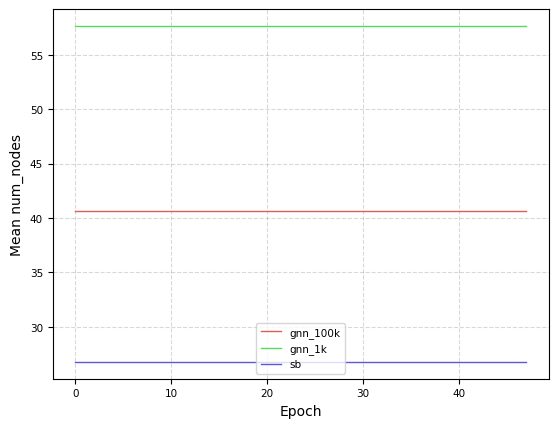

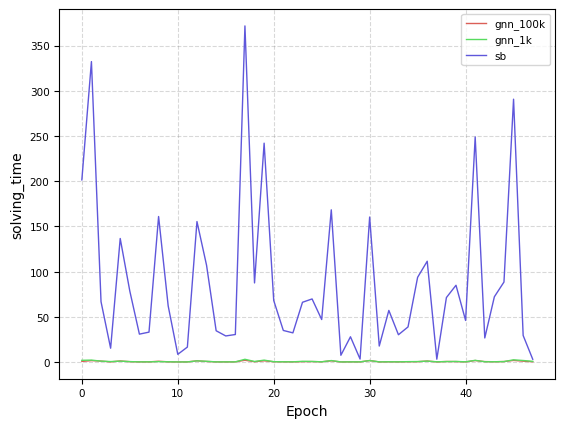

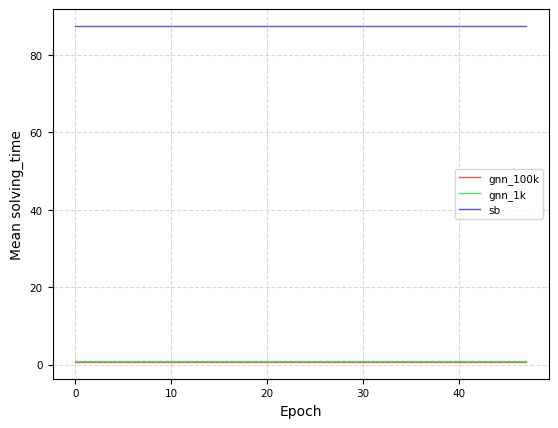

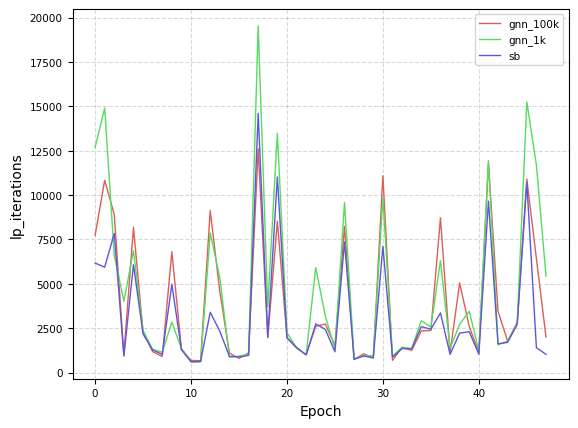

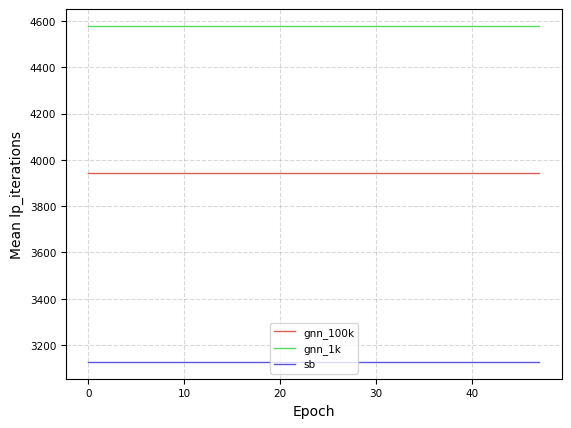

In [13]:
%autoreload
nested_dict = lambda: defaultdict(nested_dict)
plot_dicts = {metric: nested_dict() for metric in validator.metrics}

for agent in validator.epochs_log.keys():
    for metric in validator.metrics:
        plot_dicts[metric][agent]['y_values'] = validator.epochs_log[agent][metric]
        plot_dicts[metric][agent]['x_values'] = list(range(len(validator.epochs_log[agent][metric])))
        print('Agent {} mean {}: {}'.format(agent, metric, np.mean(validator.epochs_log[agent][metric])))
        
res = 1
for metric in plot_dicts.keys():
    _ = plot_val_line(plot_dicts[metric],
                      xlabel='Epoch',
                      ylabel='{}'.format(metric),
                      show_fig=True)
    _ = plot_val_line(plot_dicts[metric],
                      xlabel='Epoch',
                      ylabel='Mean {}'.format(metric),
                      smooth_data_res=res,
                      show_fig=True)